In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import rosbag

import os, sys

PYTHON_PATHS = ['/home/alena/PycharmProjects/ros-bag-processing']
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
        
        
from ros_bag_processing.enlighting.hist_norm import HistNormModel
from ros_bag_processing.enlighting.gamma import GammaModel
import utils

try:
    from enlighten_inference import EnlightenOnnxModel as EnlightenGanModel
except:
    print("Enable to import EnlightenGAN \n" 
    "Run following command: \n" 
    " pip install git+https://github.com/arsenyinfo/EnlightenGAN-inference")
    sys.exit()


In [3]:
def read_bag(file_path, type='r'):
    return rosbag.Bag(file_path, type)

def check_dir(directory):
    print("Output will be saved in directory: {}".format(directory))
    if not os.path.exists(directory):
        print('New directory created')
        os.mkdir(directory)
            
def bag2images(bag_path, out_dir='output', img_topic='/camera/image_cropped'):
    bag = read_bag(bag_path)

    check_dir(out_dir)

    cnt = 0
    for topic, msg, t in tqdm(bag.read_messages(topics=[img_topic])):
        img = np.frombuffer(msg.data, dtype=np.uint8).reshape(msg.height, msg.width, -1)
        out_im_path = os.path.join(out_dir, '%06i.png' % cnt)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(out_im_path, img)
        cnt += 1
#         print('Wrote image: %i' % cnt)
    bag.close()

In [2]:
bag_path = '/home/alena/skoltech/thesis/article/dataset/final_mockup_dataset/bags/2021-11-24-21-10-35.bag'
output_path = '/home/alena/skoltech/thesis/article/dataset/final_mockup_dataset/images/2021-11-24-21-10-35/'
topic = '/camera/image_cropped'

In [ ]:
bag2images(bag_path, out_dir=output_path, img_topic=topic)

### Image enlightning analysis

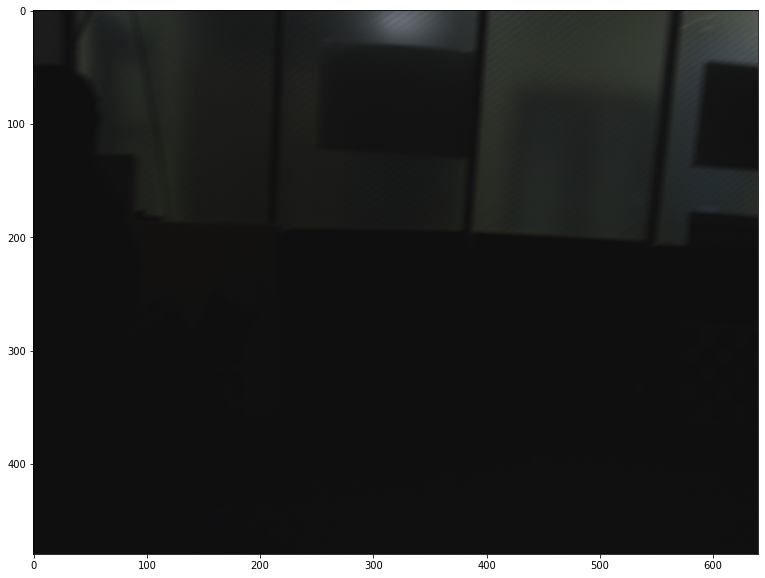

In [4]:
img = cv2.imread(output_path + '000003.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplots(figsize=(20, 10))
plt.imshow(img)

In [5]:
model_gan = EnlightenGanModel()
model_hist = HistNormModel()

In [ ]:
img_gan = model_gan.predict(img)
img_hist = model_hist.predict(img)

Text(0.5, 1.0, 'HIST Histogram, mean: 101.27')

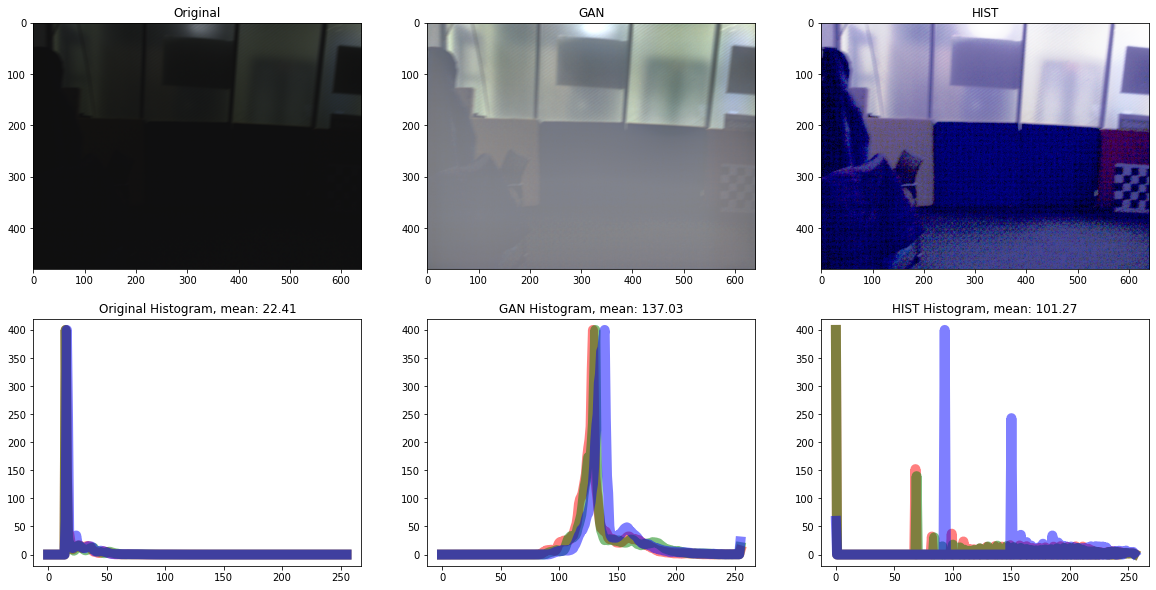

In [22]:
r_hist_hist, g_hist_hist, b_hist_hist = utils.get_rgb_hists(img_hist)
r_gan_hist, g_gan_hist, b_gan_hist = utils.get_rgb_hists(img_gan)
r_orig_hist, g_orig_hist, b_orig_hist = utils.get_rgb_hists(img)

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20,10))
ax[0, 0].imshow(img)
ax[0, 0].set_title('Original')
ax[0, 1].imshow(img_gan)
ax[0, 1].set_title('GAN')
ax[0, 2].imshow(img_hist)
ax[0, 2].set_title('HIST')

ax[1, 0].plot(r_orig_hist, 'r', alpha=0.5, linewidth=10)
ax[1, 0].plot(g_orig_hist, 'g', alpha=0.5, linewidth=10)
ax[1, 0].plot(b_orig_hist, 'b', alpha=0.5, linewidth=10)
ax[1, 0].set_title('Original Histogram, mean: ' + str(np.round(img.mean(), 2)))

ax[1, 1].plot(r_gan_hist, 'r', alpha=0.5, linewidth=10)
ax[1, 1].plot(g_gan_hist, 'g', alpha=0.5, linewidth=10)
ax[1, 1].plot(b_gan_hist, 'b', alpha=0.5, linewidth=10)
ax[1, 1].set_title('GAN Histogram, mean: ' + str(np.round(img_gan.mean(), 2)))

ax[1, 2].plot(r_hist_hist, 'r', alpha=0.5, linewidth=10)
ax[1, 2].plot(g_hist_hist, 'g', alpha=0.5, linewidth=10)
ax[1, 2].plot(b_hist_hist, 'b', alpha=0.5, linewidth=10)
ax[1, 2].set_title('HIST Histogram, mean: ' + str(np.round(img_hist.mean(), 2)))

In [62]:
h1, h2 = [250, 400]
w1, w2 = [425, -1]
img_patch = img[h1:h2, w1:w2]

In [63]:
img_gan_patch = model_gan.predict(img_patch)
img_hist_patch = model_hist.predict(img_patch)

Text(0.5, 1.0, 'HIST Histogram, mean: 42.16')

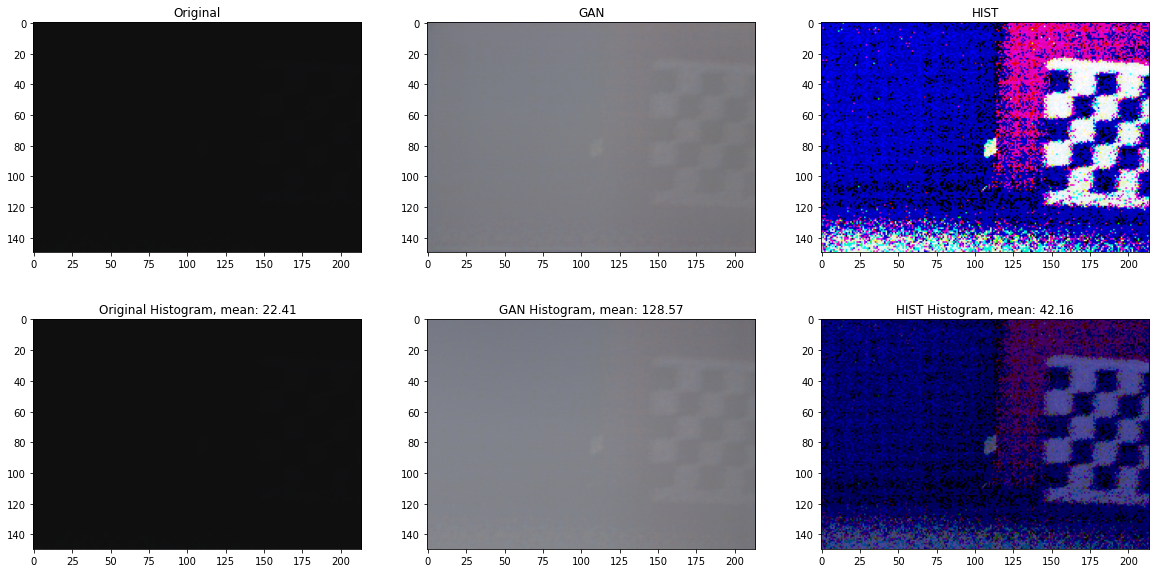

In [64]:
# r_hist_hist, g_hist_hist, b_hist_hist = utils.get_rgb_hists(img_hist_patch)
# r_gan_hist, g_gan_hist, b_gan_hist = utils.get_rgb_hists(img_gan_patch)
# r_orig_hist, g_orig_hist, b_orig_hist = utils.get_rgb_hists(img_patch)

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20,10))
ax[0, 0].imshow(img_patch)
ax[0, 0].set_title('Original')
ax[0, 1].imshow(img_gan_patch)
ax[0, 1].set_title('GAN')
ax[0, 2].imshow(img_hist_patch)
ax[0, 2].set_title('HIST')

ax[1, 0].imshow(img[h1:h2, w1:w2])
ax[1, 0].set_title('Original Histogram, mean: ' + str(np.round(img.mean(), 2)))

ax[1, 1].imshow(img_gan[h1:h2, w1:w2])
ax[1, 1].set_title('GAN Histogram, mean: ' + str(np.round(img_gan[h1:h2, w1:w2].mean(), 2)))

ax[1, 2].imshow(img_hist[h1:h2, w1:w2])
ax[1, 2].set_title('HIST Histogram, mean: ' + str(np.round(img_hist[h1:h2, w1:w2].mean(), 2)))

### Orb Extraction analysis

In [66]:
def orb_feature_exctraction(img):
    orb = cv2.ORB_create(nfeatures=2000)
    kp, descr = orb.detectAndCompute(img, None)
    orb_img = cv2.drawKeypoints(img, kp, None)
    return orb_img, kp, descr

Text(0.5, 1.0, 'GAN')

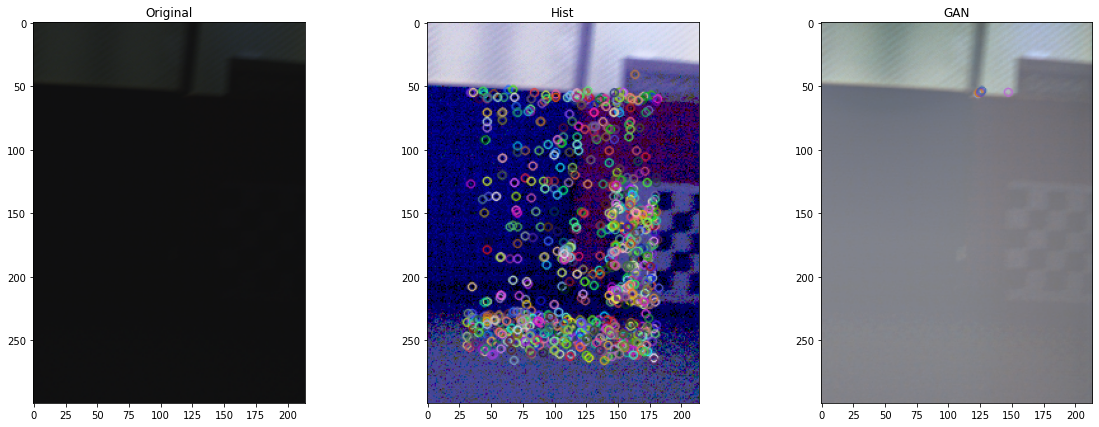

In [68]:
h1, h2 = [150, 450]
w1, w2 = [425, -1]

img_patch = img[h1:h2, w1:w2]
img_gan_patch = img_gan[h1:h2, w1:w2]
img_hist_patch = img_hist[h1:h2, w1:w2]

orb_hist, _, _ = orb_feature_exctraction(img_hist_patch)
orb_orig, _, _ = orb_feature_exctraction(img_patch)
orb_gan, _, _  = orb_feature_exctraction(img_gan_patch)

fig, ax = plt.subplots(ncols=3, figsize=(20, 7))

ax[0].imshow(orb_orig)
ax[0].set_title('Original')

ax[1].imshow(orb_hist)
ax[1].set_title('Hist')

ax[2].imshow(orb_gan)
ax[2].set_title('GAN')